# Calibration of the 4 models using CALL OPTIONS
This notebook aims to find the optimal parameters of **Black-Scholes**, **Merton Jump Diffusion**, **Kou Jump Diffusion** and **Variance Gamma** models. To do so, we compute the european option prices using **closed formulas**, available for all the 4 models, and the **Fast Fourier Transform** for the VG model. Given these theoretical prices, the **implied volatilities** are computed comparing them with real market prices, minimizing their difference. Then we estimate the additional parameters of each model, using the python module `scipy.optimize`.

*reference: https://github.com/cantaro86/Financial-Models-Numerical-Methods/tree/master*

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import scipy.optimize as scpo
import sys
sys.path.append('C:/Users\ornel\PycharmProjects\Margin-Loans-Pricing/functions')
sys.path.append('C:/Users/ornel/PycharmProjects/Margin-Loans-Pricing/calibration')
import time

from MERTONpricer import Merton_pricer
from BSpricer import BS_Pricer
from KOUpricer import Kou_pricer
from VGpricer import VG_pricer
random.seed(120)

Let's start retrieving historical prices for **european call** options starting from date **2016-01-20** and expiring **1 year** later. All the data have been collected from [OptionsDX](https://www.optionsdx.com/shop/) and preprocessed in `plainvanilla.py` module. The options that will be used in this notebook are all Out-Of-The-Money (OTM) options.

In [30]:
df_call = pd.read_csv('../../data/AAPL/OPT16_AAPL_CALLS_75_135.csv')
print(f'NUM OF CALL OPTS: {df_call.shape[0]}')
print(df_call)

NUM OF CALL OPTS: 15
    QUOTE_DATE  UNDERLYING_LAST EXPIRE_DATE  C_BID  C_ASK  STRIKE     C_IV  \
0   2016-01-20            96.79  2017-01-20  25.10  25.50    75.0  0.32883   
1   2016-01-20            96.79  2017-01-20  21.51  21.84    80.0  0.32319   
2   2016-01-20            96.79  2017-01-20  18.25  18.56    85.0  0.32009   
3   2016-01-20            96.79  2017-01-20  16.75  17.05    87.5  0.31782   
4   2016-01-20            96.79  2017-01-20  15.30  15.59    90.0  0.31582   
5   2016-01-20            96.79  2017-01-20  13.95  14.21    92.5  0.31267   
6   2016-01-20            96.79  2017-01-20  12.75  12.95    95.0  0.31286   
7   2016-01-20            96.79  2017-01-20  11.55  11.70    97.5  0.30928   
8   2016-01-20            96.79  2017-01-20  10.46  10.59   100.0  0.30723   
9   2016-01-20            96.79  2017-01-20   8.45   8.61   105.0  0.30361   
10  2016-01-20            96.79  2017-01-20   6.74   6.86   110.0  0.29915   
11  2016-01-20            96.79  2017-01-20

The dataframes **df_calls** contains 15 options sorted by their strike price, with the moneyness in range [0.75, 1.35]. For our purpose, using the $100\%$ of this DFs is enough and can lead to very good results. Thus, we sample the rows and then reformulate the dataframe adding **Midpoint** and **Spread** columns.

In [31]:
calls = df_call.sample(frac=1, replace=False).sort_index().reset_index(drop=True)
calls['C_Midpoint'] = abs(calls['C_BID'] + calls['C_ASK']) / 2
calls['C_Spread'] = calls['C_BID'] - calls['C_ASK']

q = 0           # dividend yield
r = 0.03        # risk-free interest rate
sigma = 0.3     #volatility (variance of diffusion process)
S0 = calls.iloc[0]['UNDERLYING_LAST']
T = 1           # time-to-maturity
call_strikes = calls['STRIKE']    # array of K for call options
exercise = 'european'

call_prices = calls['C_Midpoint']

The following code snippet initializes objects of class *BS_pricer*, *Merton_pricer*, *Kou_pricer*, *VG_pricer* with default values as parameters. These parameters serve only as initialization. Best fitting parameetrs will be calibrated consequently and used to correctly price the options according to each model.

In [32]:
BS = BS_Pricer(S0=S0, r=r, q = q, sigma=sigma, ttm=T, exercise=exercise, K=None)
Merton = Merton_pricer(S0=S0, K=None, ttm=T, r=r, q = q, sigma=0.15, lambd=0.5, meanJ=-0.1, stdJ=0.1, exercise=exercise)
Kou = Kou_pricer(S0=S0, K=None, ttm=T, r=r, sigma=0.15, lambd=0.5, p=0.6, eta1=12, eta2=5, exercise=exercise)
VG = VG_pricer(S0, K=None, ttm=T, r=r, q=q, sigma=0.15, theta=-0.2, nu=0.3, exercise=exercise)

## Implied volatility
The function belows implements $3$ methods to compute implied volatility: [Newton](https://en.wikipedia.org/wiki/Newton%27s_method) method, the [Bisection](https://en.wikipedia.org/wiki/Bisection_method) method and a more advanced one, named [Brent](https://en.wikipedia.org/wiki/Brent%27s_method) method. Apart from the initial guess, there is no substantial difference in the final result between **Newton** and **bisection** methods (*fsolve*). The **Implied Volatility** is that value $\sigma$ that must be inserted into the Black-Scholes (BS) formula in order to retrieve the option price quoted in the market:
    $$ BS(S, K, T, r, \sigma) = P,  $$
where $S$ is the underlying spot price, $K$ is the strike, $T$ time to maturity, $r$ risk-free interest rate and $P$ the option price quoted in the market. All these quantities are **observable**.
   

In [33]:
def implied_volatility(price, S, strike, t, rate, q, type_o, method='fsolve', disp=True ):
    """ Returns Implied volatility
        methods:  fsolve (default) or brent
    """

    def obj_fun(vol):
        return BS.BlackScholes(type_o=type_o, S0=S, K=strike, ttm=t, r=rate, q=q, sigma=vol) - price

    def vega(vol):
        return BS.vega(S, strike, rate, q, vol, t)

    if method =='fsolve':
        X0 = [0.01, 0.2, 0.35, 7]        #initial guess points for imp.vol.
        for x_0 in X0:
            x, _, solved, _ = scpo.fsolve(obj_fun, x_0, full_output=True, xtol=1e-8)
            if solved == 1:
                return x[0]

    if disp:
        return -1

The following code snippet computes the implied volatility of **call** options market prices and show a plot of the implied volatilities found by inversion method against the ones provided by the dataframe.

Implied volatilities of market prices (calls):
S0 = 96.79
K = 105.0, IV = 0.3024
K = 110.0, IV = 0.2973
K = 115.0, IV = 0.2933
K = 120.0, IV = 0.2895
K = 125.0, IV = 0.2862
K = 130.0, IV = 0.2835


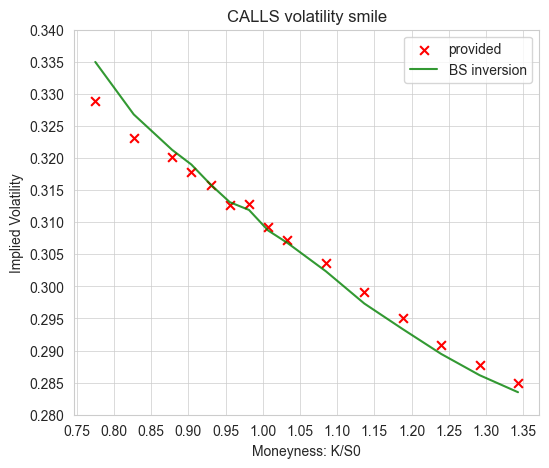

In [34]:
custom_xticks = [0.75, 0.8, 0.85, 0.9, 0.95, 1.0, 1.05, 1.1, 1.15, 1.2, 1.25, 1.3, 1.35]  # Esempio di valori personalizzati per gli xticks
custom_yticks = np.linspace(0.28, 0.34, 13)    # Esempio di valori personalizzati per gli yticks


IV_market = []
for i in range(len(call_prices)):
    IV_market.append(implied_volatility(call_prices[i], S=S0, strike=call_strikes[i], t = T, rate=0.027, q = 0.02, type_o='call', method='fsolve'))

print(f'Implied volatilities of market prices (calls):\nS0 = {S0}')
for a,b in zip(call_strikes.tail(6), IV_market[-6:]):
    print(f'K = {a}, IV = {round(b, 4)}')

# Plot market implied volatilities w.r.t. log moneyness
x = (call_strikes/S0)
IV_filtered = [iv for iv in IV_market if iv != -1]
x_filtered = [log_m for iv, log_m in zip(IV_market, x) if iv != -1]

fig, ax1 = plt.subplots(figsize=(6,5))
ax1.scatter(x, calls['C_IV'], marker='x', label='provided', color='red', s=40)
ax1.plot(x, IV_market, label='BS inversion', alpha = 0.8, color = 'green')


ax1.set_xlabel('Moneyness: K/S0'); ax1.set_ylabel('Implied Volatility'); ax1.set_title('CALLS volatility smile')
ax1.set_xticks(custom_xticks)
ax1.set_yticks(custom_yticks)
ax1.legend(); plt.grid(True, linewidth=0.5); plt.show()


##  Weighted Calibration (call options)
Let's step now into the calibration of model parameters.
If we define $\Theta$ the set of parameters, the goal is to find the optimal parameters $\Theta^*$ that minimize the following objective function:
$$ \sum_{i=1}^{N} w_i \biggl( P_i - f(K_i|\Theta) \biggr)^2 $$
where $w_i$ are weights, usually defined as
$$ w_i = \frac{1}{\text {spread}_i },$$ $P_i$ are the market prices and $f$ is the pricing function. In our case $f$ is given by **Merton** Jump Diffusion model, **Kou** Jump Diffusion model, or **Variance Gamma** process. To perform this optimization problem, many numerical methods can be used. In particular, we test two functions of `scipy.optimize`:
1. **curve_fit**, a least-squares curve fitting method which works with bounds. The default algorithm is [Trust Region Reflective (trf)](https://en.wikipedia.org/wiki/Trust_region). The [Levemberg-Marquadt](https://en.wikipedia.org/wiki/Levenberg%E2%80%93Marquardt_algorithm) has been tried as well, to test the optimization problem without setting boundaries, but the results don't make any sense.
2. **Least-Squares**, a constrained minimization problem which uses Trust region reflective method by default. This method is the most indicated to solve the non-linear least squares optimization problem of our purpose.
All the optimizations are carried out by initializing a starting point as the array $x_0 = [params]$ and setting feasible bounds.


In [35]:
call_spreads = calls['C_Spread']
c_weights = 1/ call_spreads**2

### Black and Scholes model
The only unknown parameter to calibrate in Black and Scholes model is the **implied volatility**, $\sigma$. Thus, we minimize the difference between the computed theoretical prices and the market prices of call options.

In [8]:
x0 = 0.5
bounds = [1e-5, 2]

def f_BlackScholes_calls(x, sigm):
    BS = BS_Pricer(S0=S0, K = x, ttm=T, r=r, q=0, sigma=sigm, exercise=exercise)
    return BS.closed_formula_call(x)

res1_calls = scpo.curve_fit(f_BlackScholes_calls, call_strikes, call_prices, p0 = x0, bounds=bounds, sigma=c_weights)
sigw_p = round(res1_calls[0][0],4)

In [9]:
def cost_function(x, strikes, mkt_prices):
    sigma = x
    BS = BS_Pricer(S0=S0, K = None, ttm=T, r=r, q=0, sigma=sigma, exercise=exercise)
    sq_err = np.sum(c_weights* (BS.closed_formula_call(strikes) - mkt_prices)**2)
    return sq_err

result_p = scpo.least_squares(cost_function, x0, args=(call_strikes, call_prices), bounds=bounds, method = 'trf', verbose=1)
calls_bs_params_aapl = result_p.x[0]

`ftol` termination condition is satisfied.
Function evaluations 26, initial cost 1.0523e+09, final cost 4.0104e+01, first-order optimality 1.07e-01.


In [10]:
print('METHOD 1: CURVE_FIT (trf)')
print(f'> Calibrated Volatility from Calls [σ] = {sigw_p} \t {round(sigw_p*100,2)}%')
print('METHOD 2: LEAST-SQUARES (trf)')
print(f'> Calibrated Volatility from Calls [σ] = {calls_bs_params_aapl} \t {round(calls_bs_params_aapl*100,2)}%')

METHOD 1: CURVE_FIT (trf)
> Calibrated Volatility from Calls [σ] = 0.2674 	 26.74%
METHOD 2: LEAST-SQUARES (trf)
> Calibrated Volatility from Calls [σ] = 0.2724253089915217 	 27.24%


Save parameters to use them in other notebooks

In [11]:
%store calls_bs_params_aapl

Stored 'calls_bs_params_aapl' (float64)


### Merton Jump Diffusion
The Merton Jump diffusion ones are the volatility $\sigma$, the Poisson rate of jumps $\lambda$, the mean rate of jump intensity $m$ and its variance rate $v$, assuming that the intensity of jumps follows a *Normal distribution*.


In [12]:
x0 = [0.15,  0.2, -0.05,  0.01]  # initial guess: [σ, λ, m, v]
bounds = ( [1e-3, 1e-2, -5, 1e-5], [2, 5, 5, 2] )

In [13]:
def f_Mert(x, sigma, lambd, meanJ, stdJ):
    Mert = Merton_pricer(S0=S0, K=x, ttm=T, r=r, q=0, sigma=sigma, lambd=lambd, meanJ=meanJ, stdJ=stdJ, exercise=exercise)
    return Mert.closed_formula_call(x)

start1=time.time()
mert1 = scpo.curve_fit(f_Mert, call_strikes, call_prices, p0=x0, bounds=bounds, sigma=call_spreads)
end1=time.time()

mert_params1 = [round(p,4) for p in mert1[0][:4]]

##### Method 2. Least-squares

In [14]:
x0 = [0.15,  0.5, -0.05,  0.1]      # initial guess: [σ, λ, m, v]
bounds = ( [1e-3, 1e-2, -10, 0], [2, 10, 5, 5] )

def cost_function(x, strikes, mkt_prices):
    sigma, lambd, meanJ, stdJ = x
    M = Merton_pricer(S0, None, T, r, q, sigma, lambd, meanJ, stdJ, exercise)
    sq_err = np.sum(c_weights*(M.closed_formula_call(strikes) - mkt_prices)**2)
    return sq_err

start2 = time.time()
mert2 = scpo.least_squares(cost_function, x0, args=(call_strikes, call_prices), bounds=bounds, method = 'trf', verbose=2)
end2 = time.time()

mert_params2 = [round(p,4) for p in mert2.x[:4]]

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.7193e+07                                    1.52e+09    
       1              2         1.4070e+06      2.58e+07       6.24e-01       1.43e+08    
       2              3         1.9138e+05      1.22e+06       8.58e-02       1.79e+07    
       3              4         1.6650e+05      2.49e+04       8.87e-01       4.25e+07    
       4              6         1.1042e+05      5.61e+04       7.62e-02       2.54e+07    
       5              8         4.9326e+04      6.11e+04       1.30e-02       5.83e+06    
       6             10         3.9195e+04      1.01e+04       5.19e-03       2.98e+06    
       7             11         3.2691e+04      6.50e+03       5.33e-03       4.23e+06    
       8             12         2.2481e+04      1.02e+04       1.52e-02       2.72e+06    
       9             13         1.0728e+04      1.18e+04       2.86e-02       2.70e+06    

In [15]:
print('WEIGHTED OPT: CURVE_FIT (trf)')
print(f'> Calibrated Volatlity [σ] = {round(mert1[0][0],4)} \t {round(mert1[0][0]*100,2)}%')
print('> Calibrated Jump intensity [λ] = ', round(mert1[0][1],2))
print('> Calibrated Jump Mean = ', round(mert1[0][2],2))
print('> Calibrated Jump St. dev.  = ', round(mert1[0][3],5))
print(f'ELAPSED TIME: {end1-start1} sec')

print('\nMETHOD 1: LEAST SQUARES (trf)')
print(f'> Calibrated Volatlity [σ] = {mert_params2[0]} \t {round(mert_params2[0]*100,2)}%')
print('> Calibrated Jump intensity [λ] = ', round(mert_params2[1],2))
print('> Calibrated Jump Mean = ', round(mert_params2[2],3))
print('> Calibrated Jump St. dev.  = ', round(mert_params2[3],3))
print(f'TIME ELAPSED:  {round(end2-start2,2)} sec')

WEIGHTED OPT: CURVE_FIT (trf)
> Calibrated Volatlity [σ] = 0.2168 	 21.68%
> Calibrated Jump intensity [λ] =  5.0
> Calibrated Jump Mean =  -0.08
> Calibrated Jump St. dev.  =  1e-05
ELAPSED TIME: 32.08518719673157 sec

METHOD 1: LEAST SQUARES (trf)
> Calibrated Volatlity [σ] = 0.2548 	 25.48%
> Calibrated Jump intensity [λ] =  0.24
> Calibrated Jump Mean =  -0.122
> Calibrated Jump St. dev.  =  0.197
TIME ELAPSED:  81.89 sec


In [1]:
print(mert_params2)
calls_mert_params_aapl = mert_params2
%store calls_mert_params_aapl

NameError: name 'mert_params2' is not defined

### Kou Jump Diffusion


In [17]:
x0 = [0.2, 0.7, 0.5, 8, 10] # initial guess: [σ, λ, p, η_1, η_2]
bounds = ( [1e-2, 1e-1, 0, 0.5, 0.5], [0.5, 4, 1, 15, 20] )

##### Method 1. TRF (Bounds)

In [18]:
# def f_Kou(x, sigma, lambd, p, eta1, eta2):
#     KouJD = Kou_pricer(S0=S0, K=x, ttm=T, r=r, sigma=sigma, lambd=lambd, p=p, eta1=eta1, eta2=eta2, exercise=exercise)
#     return KouJD.closed_formula_call(x)
#
# start1 = time.time()
# kou1 = scpo.curve_fit(f_Kou, call_strikes, call_prices, p0=x0, bounds=bounds, sigma=c_weights)
# end1 = time.time()
#
# kou_params1 = [round(p,4) for p in kou1[0][:5]]

##### Method 2. LEAST SQUARES (With Bounds)

In [ ]:
kou_params2 = [round(p,4) for p in kou2.x[:5]]

In [ ]:
# print('WEIGHTED OPT: CURVE_FIT (trf)')
# print(f'> Calibrated Volatlity [σ] = {kou_params1[0]} \t {kou_params1[0] * 100}%')
# print('> Calibrated Jump intensity [λ] = ', kou_params1[1])
# print(f'> Calibrated Upward Jump probability [p] = {kou_params1[2]}, [q] = {round(1 - kou_params1[2], 2)}')
# print('> Calibrated Rate of Exp. 1  [η_1] = ', kou_params1[3])
# print('> Calibrated Rate of Exp. 2  [η_2] = ', kou_params1[4])
# print(f'TIME ELAPSED: {end1-start1} sec')

In [2]:
print('METHOD 2: Least-squares')
print(f'> Calibrated Volatlity [σ] = {round(kou_params2[0],4)} \t {round(kou_params2[0]*100,2)}%')
print('> Calibrated Jump intensity [λ] = ', round(kou_params2[1],2))
print(f'> Calibrated Upward Jump probability [p] = {round(kou_params2[2],2)}, [q] = {round(1-kou_params2[2],2)}')
print('> Calibrated Rate of Exp. 1  [η_1] = ', round(kou_params2[3],2))
print('> Calibrated Rate of Exp. 2  [η_2] = ', round(kou_params2[4],2))
print(f'TIME ELAPSED:  {round(end2-start2,2)} sec')

METHOD 2: Least-squares


NameError: name 'kou_params2' is not defined

In [ ]:
calls_kou_params_aapl = kou_params2
%store calls_kou_params_aapl
print(kou_params2)

### Variance Gamma


In [ ]:
x0 = [0.25, -0.2, 0.2]   # initial guess: [σ, θ, v]
bounds = ( [1e-3, -5, 0], [1, 5, 5] )

##### Method 1. CURVE FIT (Bounds)

In [ ]:
def f_VG(strikes, sigmax, thetax, nux):
    VGamma = VG_pricer(S0=S0, K=None, ttm=T, r=r, q=0, sigma=sigmax, theta=thetax, nu=nux, exercise=exercise)
    vg_prices = []
    for k in strikes:
        vg_prices.append(VGamma.closed_formula_call(k))
    return vg_prices

start1 = time.time()
vg1 = scpo.curve_fit(f_VG, call_strikes, call_prices, p0=x0, bounds=bounds, sigma=c_weights)
end1 = time.time()

vg_params1 = [round(p,4) for p in vg1[0][:3]]

##### Method 2. LEAST-SQUARES (Trust Region Reflective, Bounds)

In [ ]:
def cost_function(x, strikes, mkt_prices):
    sigma, theta, nu = x
    VG = VG_pricer(S0, None, T, r, q, sigma, theta, nu, exercise)
    prices = []
    for k in strikes:
        prices.append(VG.closed_formula_call(k))
    sq_err = np.sum(c_weights*(prices - mkt_prices)**2)
    return sq_err

start2=time.time()
vg2 = scpo.least_squares(cost_function, x0, args=(call_strikes, call_prices),  method='trf', bounds=bounds, verbose=2, loss='soft_l1')
end2=time.time()

vg_params2 = [round(p,4) for p in vg2.x[:3]]

In [ ]:
print('WEIGHTED OPT: CURVE_FIT (trf)')
print(f'> Calibrated Volatlity [σ] = {vg_params1[0]}, \t {round(vg_params1[0]*100,2)}%')
print('> Calibrated mean rate gamma process [θ] = ', vg_params1[1])
print('> Calibrated variance rate gamma process [v]= ', vg_params1[2])
print(f'TIME ELAPSED:  {round(end1-start1,2)} sec')

print('METHOD 1: LEAST-SQUARES (trf)')
print(f'> Calibrated Volatlity [σ] = {vg_params2[0]}, \t {round(vg_params2[0]*100,2)}%')
print('> Calibrated mean rate gamma process [θ] = ', vg_params2[1])
print('> Calibrated variance rate gamma process [v]= ', vg_params2[2])
print(f'TIME ELAPSED:  {round(end2-start2,2)} sec')

In [ ]:
print(vg_params1)
print(vg_params2)
calls_vg_params_aapl = vg_params2
%store calls_vg_params_aapl

#### For when you don't want to recalibrate. Otherwise comment this cell

In [42]:
%store -r calls_bs_params_aapl
%store -r calls_mert_params_aapl
%store -r calls_kou_params_aapl
%store -r calls_vg_params_aapl

bs_param = calls_bs_params_aapl
m_params = calls_mert_params_aapl
k_params = calls_kou_params_aapl
vg_params = calls_vg_params_aapl


### Reprice options using calibrated parameters
Once we have calibrated all the models, we test our parameters calibration by repricing the original dataframe of options. The table contains all the **BID**, **ASK** and **MIDPOINT** prices. The calibration is well perfromed if the prices we obtain belong to the interval $[BID, ASK]$.

In [43]:
days = 252
paths = 1000

call_calib_prices = pd.DataFrame({
    'STRIKE': calls['STRIKE'],    # array of K for call options
    'MKT_BID': calls['C_BID'],
    'MKT_MID': calls['C_Midpoint'],
    'MKT_ASK': calls['C_ASK'],
})
print(f'MARKET PRICES. STARTING DATE = 20-01-2016. EXPIRY = 1YEAR. \n\n{call_calib_prices}')

MARKET PRICES. STARTING DATE = 20-01-2016. EXPIRY = 1YEAR. 

    STRIKE  MKT_BID  MKT_MID  MKT_ASK
0     75.0    25.10   25.300    25.50
1     80.0    21.51   21.675    21.84
2     85.0    18.25   18.405    18.56
3     87.5    16.75   16.900    17.05
4     90.0    15.30   15.445    15.59
5     92.5    13.95   14.080    14.21
6     95.0    12.75   12.850    12.95
7     97.5    11.55   11.625    11.70
8    100.0    10.46   10.525    10.59
9    105.0     8.45    8.530     8.61
10   110.0     6.74    6.800     6.86
11   115.0     5.30    5.375     5.45
12   120.0     4.15    4.195     4.24
13   125.0     3.20    3.245     3.29
14   130.0     2.44    2.495     2.55


#### Merton Jump Diffusion model

In [44]:
sigma, lambd, meanJ, stdJ = m_params
MertonCAL = Merton_pricer(S0, None, T, r, q, sigma, lambd, meanJ, stdJ, exercise)
SMerton_CAL = MertonCAL.MertonPath(days, paths)

avg_payoffs = []
for k in call_strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for St in SMerton_CAL[-1]:
        payoffs.append(MertonCAL.payoff_call(k, St))
    avg_payoffs.append(np.mean(payoffs))

merton_mc_prices = np.zeros(len(call_calib_prices))
merton_cf_prices = np.zeros(len(call_calib_prices))

for index in range(len(call_calib_prices)):
    merton_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index]
    merton_cf_prices[index] = MertonCAL.closed_formula_call(call_strikes[index])

call_calib_prices['MERTON MC'] = merton_mc_prices
call_calib_prices['MERTON CF'] = merton_cf_prices

print(call_calib_prices)

    STRIKE  MKT_BID  MKT_MID  MKT_ASK  MERTON MC  MERTON CF
0     75.0    25.10   25.300    25.50  26.434757  25.910596
1     80.0    21.51   21.675    21.84  22.677296  22.093244
2     85.0    18.25   18.405    18.56  19.212092  18.615267
3     87.5    16.75   16.900    17.05  17.621379  17.012883
4     90.0    15.30   15.445    15.59  16.134973  15.504450
5     92.5    13.95   14.080    14.21  14.727496  14.090797
6     95.0    12.75   12.850    12.95  13.414405  12.771740
7     97.5    11.55   11.625    11.70  12.193403  11.546155
8    100.0    10.46   10.525    10.59  11.067435  10.412079
9    105.0     8.45    8.530     8.61   9.111479   8.407056
10   110.0     6.74    6.800     6.86   7.456952   6.728473
11   115.0     5.30    5.375     5.45   6.057227   5.342088
12   120.0     4.15    4.195     4.24   4.903700   4.210975
13   125.0     3.20    3.245     3.29   3.969013   3.298213
14   130.0     2.44    2.495     2.55   3.205686   2.568826


In [45]:
sigma, lambd, p, eta1, eta2 = k_params
KouCAL = Kou_pricer(S0, None, T, r, sigma, lambd, p, eta1, eta2, exercise)
SKou_CAL = KouCAL.KouPath(days, paths)

avg_payoffs = []
for k in call_strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for St in SKou_CAL[-1]:
        payoffs.append(KouCAL.payoff_call(k, St))
    avg_payoffs.append(np.mean(payoffs))

kou_mc_prices = np.zeros(len(call_calib_prices))
kou_cf_prices = np.zeros(len(call_calib_prices))

for index in range(len(call_calib_prices)):
    kou_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index]
    kou_cf_prices[index] = KouCAL.closed_formula_call(call_strikes[index])

call_calib_prices['KOU MC'] = kou_mc_prices
call_calib_prices['KOU CF'] = kou_cf_prices

selection = [0,1,2,3,6,7]
print(call_calib_prices.iloc[:, selection])

    STRIKE  MKT_BID  MKT_MID  MKT_ASK     KOU MC     KOU CF
0     75.0    25.10   25.300    25.50  24.722788  25.742058
1     80.0    21.51   21.675    21.84  20.983960  21.912847
2     85.0    18.25   18.405    18.56  17.565040  18.437558
3     87.5    16.75   16.900    17.05  16.018660  16.842138
4     90.0    15.30   15.445    15.59  14.559647  15.344211
5     92.5    13.95   14.080    14.21  13.192103  13.944301
6     95.0    12.75   12.850    12.95  11.939666  12.641824
7     97.5    11.55   11.625    11.70  10.774267  11.435189
8    100.0    10.46   10.525    10.59   9.713001  10.321920
9    105.0     8.45    8.530     8.61   7.881355   8.361977
10   110.0     6.74    6.800     6.86   6.383566   6.729738
11   115.0     5.30    5.375     5.45   5.135598   5.387486
12   120.0     4.15    4.195     4.24   4.106638   4.295690
13   125.0     3.20    3.245     3.29   3.279899   3.415784
14   130.0     2.44    2.495     2.55   2.644314   2.712023


In [46]:
sigm, theta, nu = vg_params
VGCAL = VG_pricer(S0, None, T, r, q, sigm, theta, nu, exercise)
SVarGamma_CAL = VGCAL.VarianceGammaPath2(days, paths)

avg_payoffs = []
for k in call_strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for St in SVarGamma_CAL[-1]:
        payoffs.append(VGCAL.payoff_call(k, St))
    avg_payoffs.append(np.mean(payoffs))

vg_mc_prices = np.zeros(len(call_calib_prices))
vg_cf_prices = np.zeros(len(call_calib_prices))

for index in range(len(call_calib_prices)):
    vg_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index]
    vg_cf_prices[index] = VGCAL.closed_formula_call(call_strikes[index])

call_calib_prices['VG MC'] = vg_mc_prices
call_calib_prices['VG CF'] = vg_cf_prices

selection = [0,1,2,3,8,9]
print(call_calib_prices.iloc[:, selection])

    STRIKE  MKT_BID  MKT_MID  MKT_ASK      VG MC      VG CF
0     75.0    25.10   25.300    25.50  25.520035  26.045815
1     80.0    21.51   21.675    21.84  21.727384  22.220420
2     85.0    18.25   18.405    18.56  18.339133  18.718857
3     87.5    16.75   16.900    17.05  16.807133  17.100379
4     90.0    15.30   15.445    15.59  15.360862  15.574199
5     92.5    13.95   14.080    14.21  14.026742  14.142175
6     95.0    12.75   12.850    12.95  12.795817  12.805145
7     97.5    11.55   11.625    11.70  11.660343  11.562924
8    100.0    10.46   10.525    10.59  10.618083  10.414337
9    105.0     8.45    8.530     8.61   8.773508   8.388840
10   110.0     6.74    6.800     6.86   7.208939   6.702628
11   115.0     5.30    5.375     5.45   5.906292   5.320486
12   120.0     4.15    4.195     4.24   4.838500   4.202410
13   125.0     3.20    3.245     3.29   3.941131   3.307607
14   130.0     2.44    2.495     2.55   3.210389   2.597484


In [47]:
print(call_calib_prices)

    STRIKE  MKT_BID  MKT_MID  MKT_ASK  MERTON MC  MERTON CF     KOU MC  \
0     75.0    25.10   25.300    25.50  26.434757  25.910596  24.722788   
1     80.0    21.51   21.675    21.84  22.677296  22.093244  20.983960   
2     85.0    18.25   18.405    18.56  19.212092  18.615267  17.565040   
3     87.5    16.75   16.900    17.05  17.621379  17.012883  16.018660   
4     90.0    15.30   15.445    15.59  16.134973  15.504450  14.559647   
5     92.5    13.95   14.080    14.21  14.727496  14.090797  13.192103   
6     95.0    12.75   12.850    12.95  13.414405  12.771740  11.939666   
7     97.5    11.55   11.625    11.70  12.193403  11.546155  10.774267   
8    100.0    10.46   10.525    10.59  11.067435  10.412079   9.713001   
9    105.0     8.45    8.530     8.61   9.111479   8.407056   7.881355   
10   110.0     6.74    6.800     6.86   7.456952   6.728473   6.383566   
11   115.0     5.30    5.375     5.45   6.057227   5.342088   5.135598   
12   120.0     4.15    4.195     4.24 

### Visualize calibration results

#### Closed Formulas Option pricing

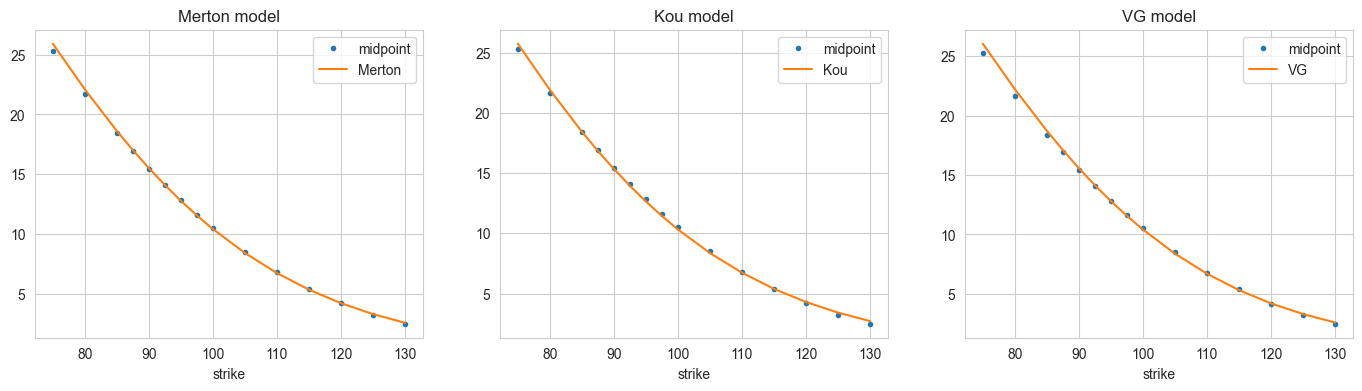

In [48]:
fig = plt.figure(figsize=(17, 4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.plot(call_strikes, call_prices, ".", label="midpoint")
ax2.plot(call_strikes, call_prices, ".", label="midpoint")
ax3.plot(call_strikes, call_prices, ".", label="midpoint")
ax1.plot(call_strikes, merton_cf_prices, label="Merton")
ax2.plot(call_strikes, kou_cf_prices, label="Kou")
ax3.plot(call_strikes, vg_cf_prices, label="VG")
ax1.set_title("Merton model")
ax2.set_title("Kou model")
ax3.set_title("VG model")
ax1.set_xlabel("strike")
ax2.set_xlabel("strike")
ax3.set_xlabel("strike")
ax1.legend()
ax2.legend()
ax3.legend()
plt.show()

#### Monte Carlo option pricing

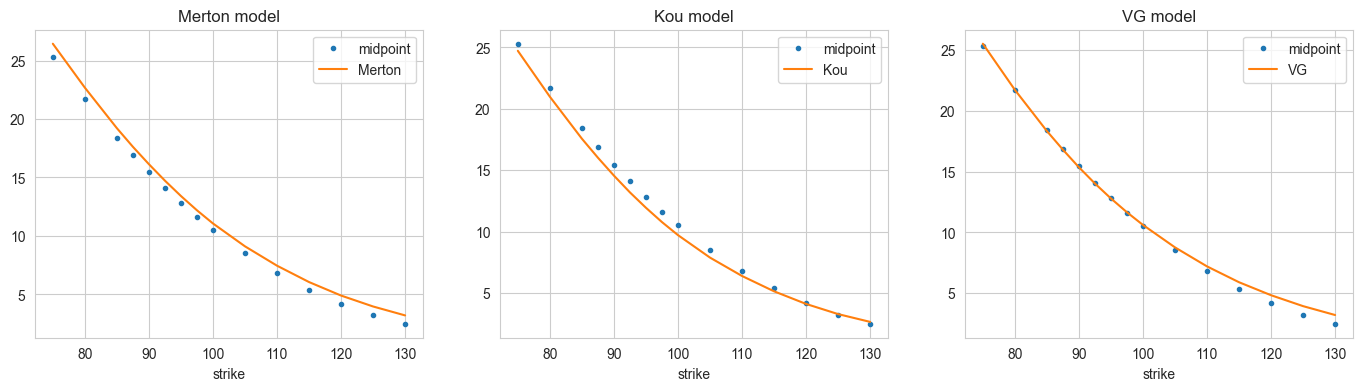

In [49]:
fig = plt.figure(figsize=(17, 4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.plot(call_strikes, call_prices, ".", label="midpoint")
ax2.plot(call_strikes, call_prices, ".", label="midpoint")
ax3.plot(call_strikes, call_prices, ".", label="midpoint")
ax1.plot(call_strikes, merton_mc_prices, label="Merton")
ax2.plot(call_strikes, kou_mc_prices, label="Kou")
ax3.plot(call_strikes, vg_mc_prices, label="VG")
ax1.set_title("Merton model")
ax2.set_title("Kou model")
ax3.set_title("VG model")
ax1.set_xlabel("strike")
ax2.set_xlabel("strike")
ax3.set_xlabel("strike")
ax1.legend()
ax2.legend()
ax3.legend()
plt.show()

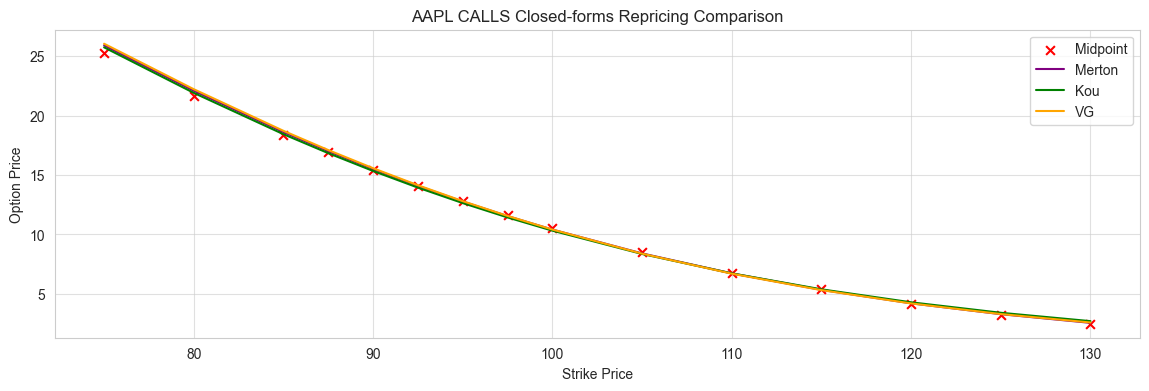

In [70]:
fig, ax = plt.subplots(figsize=(14, 4))

# Plot the first subplot (Merton model)
ax.scatter(call_strikes, call_prices, marker='x', color='red', label="Midpoint",  s=40)
ax.plot(call_strikes, merton_cf_prices, label="Merton", color="purple")

# Plot the second subplot (Kou model)
ax.plot(call_strikes, kou_cf_prices, label="Kou", color="green")

# Plot the third subplot (VG model)
ax.plot(call_strikes, vg_cf_prices, label="VG", color="orange")

ax.set_title("AAPL CALLS Closed-forms Repricing Comparison")
ax.set_xlabel("Strike Price")
ax.set_ylabel("Option Price")
ax.legend()
plt.grid(True, linestyle="-", alpha=0.6)
plt.show()


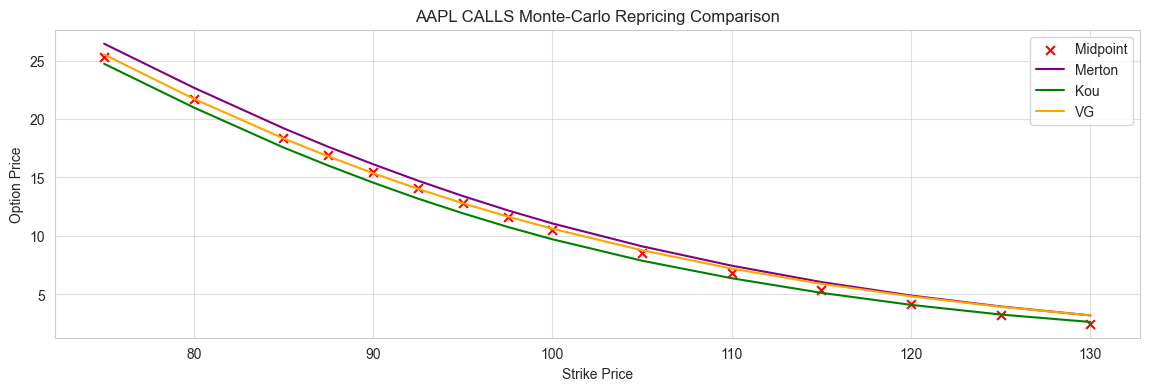

In [71]:
fig, ax = plt.subplots(figsize=(14, 4))

# Plot the first subplot (Merton model)
ax.scatter(call_strikes, call_prices, marker='x', color='red', label="Midpoint",  s=40)
ax.plot(call_strikes, merton_mc_prices, label="Merton", color="purple")

# Plot the second subplot (Kou model)
ax.plot(call_strikes, kou_mc_prices, label="Kou", color="green")

# Plot the third subplot (VG model)
ax.plot(call_strikes, vg_mc_prices, label="VG", color="orange")

ax.set_title("AAPL CALLS. Monte-Carlo Repricing Comparison")
ax.set_xlabel("Strike Price")
ax.set_ylabel("Option Price")
ax.legend()
plt.grid(True, linestyle="-", alpha=0.6)
plt.show()